In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("./mini_100000.csv")

In [5]:
data.sample(10)

,unique_identifier,native word,english word
60780,nep60781,गार्डेनले,gardenle
54519,nep54520,केवेतको,kewetko
10606,nep10607,तौलमात्रै,taulamatrai
5214,nep5215,टम्टा,tamta
42306,nep42307,कलशयात्री,kalshayatri
38033,nep38034,उद्योगपतिलगायतले,udyogpatilgayatle
43309,nep43310,गनजम,ganajam
48554,nep48555,श्रीविलास,srivilas
1856,nep1857,सुन्नु,sunnu
23476,nep23477,अर्दलीसम्म,ardalisamma


## Data Preparation

In [6]:
devanagari_words = data["native word"].values
roman_words = data["english word"].values

In [7]:
len(devanagari_words), len(roman_words)

(100000, 100000)

In [8]:
devanagari_characters = set()
roman_characters = set()

for word in devanagari_words:
    for character in word:
        devanagari_characters.add(character)

for word in roman_words:
    for character in word:
        roman_characters.add(character)

In [9]:
devanagari_characters = sorted(list(devanagari_characters))
roman_characters = sorted(list(roman_characters))

In [10]:
devanagari_words[:10], roman_words[:10]

(array(['मुस्कुराउँदै', 'मान्दछन्', 'भएझैं', 'हराउँछ', 'मुन्टो', 'सोचेर',
        'प्रवृत्तिलाई', 'भट्टाचार्यले', 'सर्दै', 'मूर्तिहरू'], dtype=object),
 array(['muskuraundai', 'mandachhan', 'bhaejhain', 'haraaunchha', 'munto',
        'sochera', 'prawrittilai', 'bhattacharyale', 'sardai', 'murtiharu'],
       dtype=object))

In [11]:
max_input_sequence_length = max([len(x) for x in devanagari_words])
max_output_sequence_length = max([len(x) for x in roman_words])

max_input_sequence_length, max_output_sequence_length

(19, 27)

In [12]:
print(f"Number of samples: {len(devanagari_words)}")
print(f"Number of unique input characters: {len(devanagari_characters)}")
print(f"Number of unique output characters: {len(roman_characters)}")
print(f"Max sequence length for inputs before: {max_input_sequence_length}")
print(f"Max sequence length for outputs before: {max_output_sequence_length}")

Number of samples: 100000
Number of unique input characters: 63
Number of unique output characters: 26
Max sequence length for inputs before: 19
Max sequence length for outputs before: 27


## Preparing data for Encoder and Decoder
We need to prepare the data for encoder input which will be devanagari words and for decoder input while training will be roman words and the target words is just same as the decoder input but one timestep ahead.

In [13]:
# preparing our vocabulary
unk_token = "?"
pad_token = "_"
start_token = "<"
end_token = ">"

In [14]:
special_tokens = [unk_token, pad_token, start_token, end_token]

In [15]:
roman_vocab = special_tokens + list(roman_characters)
devanagari_vocab = [unk_token, pad_token] + list(devanagari_characters)

In [16]:
len(roman_vocab), len(devanagari_vocab)

(30, 65)

In [17]:
stoi_roman = {ch:i for i,ch in enumerate(roman_vocab)}
stoi_devanagari = {ch:i for i,ch in enumerate(devanagari_vocab)}

In [18]:
stoi_roman[unk_token] == stoi_devanagari[unk_token]

True

In [19]:
input_texts = devanagari_words
target_texts = []

for word in roman_words:
  target_texts.append(start_token + word + end_token)

In [20]:
max_input_sequence_length = max([len(x) for x in input_texts])
max_output_sequence_length = max([len(x) for x in target_texts])

max_input_sequence_length, max_output_sequence_length

(19, 29)

In [21]:
input_texts[:10], target_texts[:10]

(array(['मुस्कुराउँदै', 'मान्दछन्', 'भएझैं', 'हराउँछ', 'मुन्टो', 'सोचेर',
        'प्रवृत्तिलाई', 'भट्टाचार्यले', 'सर्दै', 'मूर्तिहरू'], dtype=object),
 ['<muskuraundai>',
  '<mandachhan>',
  '<bhaejhain>',
  '<haraaunchha>',
  '<munto>',
  '<sochera>',
  '<prawrittilai>',
  '<bhattacharyale>',
  '<sardai>',
  '<murtiharu>'])

In [22]:
num_encoder_tokens = len(devanagari_vocab)
num_decoder_tokens = len(roman_vocab)

num_encoder_tokens, num_decoder_tokens

(65, 30)

In [23]:
max_input_sequence_length, max_output_sequence_length

(19, 29)

In [24]:
encoder_input_data = np.zeros(
    (len(input_texts), max_input_sequence_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_output_sequence_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_output_sequence_length, num_decoder_tokens), dtype="float32"
)

encoder_input_data.shape, decoder_input_data.shape, decoder_input_data.shape

((100000, 19, 65), (100000, 29, 30), (100000, 29, 30))

In [25]:
stoi_roman

{'?': 0,
 '_': 1,
 '<': 2,
 '>': 3,
 'a': 4,
 'b': 5,
 'c': 6,
 'd': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'h': 11,
 'i': 12,
 'j': 13,
 'k': 14,
 'l': 15,
 'm': 16,
 'n': 17,
 'o': 18,
 'p': 19,
 'q': 20,
 'r': 21,
 's': 22,
 't': 23,
 'u': 24,
 'v': 25,
 'w': 26,
 'x': 27,
 'y': 28,
 'z': 29}

In [26]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
  for t, character in enumerate(input_text): # each word iterating
    encoder_input_data[i, t, stoi_devanagari[character]] = 1.0
  # if the word is sometimes less than the max seq then just add the padding token which has 0 index and in one hot encoding the position will be [1 0 0...]
  encoder_input_data[i, t+1: , stoi_devanagari["_"]] = 1.0 # padding for min length word

  for t, character in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
    decoder_input_data[i, t, stoi_roman[character]] = 1.0
    if t > 0:
      # decoder target data ahead by 1 timestep and dont include start character "<"
      decoder_target_data[i, t - 1, stoi_roman[character]] = 1.0 # just start storing the ohe vector only after a timestep but start from index 0 so
      # when start at t=1 store at position 0 but store next character after "start" token

  decoder_input_data[i, t+1:, stoi_roman["_"]] = 1.0
  # padding to match the length of all word
  decoder_target_data[i, t:, stoi_roman["_"]] = 1.0

In [27]:
encoder_test_data = encoder_input_data[-5000:]
decoder_input_test_data = decoder_input_data[-5000:]
decoder_target_test_data = decoder_target_data[-5000:]

encoder_input_data = encoder_input_data[:-5000]
decoder_input_data = decoder_input_data[:-5000]
decoder_target_data = decoder_target_data[:-5000]

encoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape

((95000, 19, 65), (95000, 29, 30), (95000, 29, 30))

In [28]:
encoder_input_data[10].shape

(19, 65)

In [29]:
decoder_input_data[0].shape

(29, 30)

In [30]:
decoder_target_data[0].shape

(29, 30)

In [31]:
for t, t_ in zip(decoder_input_data[0], decoder_target_data[0]):
  print(f"When input is {np.argmax(t)} : target is {np.argmax(t_)}")
  if np.argmax(t_) == 3:
    print("End of token")
    break

When input is 2 : target is 16
When input is 16 : target is 24
When input is 24 : target is 22
When input is 22 : target is 14
When input is 14 : target is 24
When input is 24 : target is 21
When input is 21 : target is 4
When input is 4 : target is 24
When input is 24 : target is 17
When input is 17 : target is 7
When input is 7 : target is 4
When input is 4 : target is 12
When input is 12 : target is 3
End of token


In [32]:
stoi_roman[end_token]

3

## Encoder Decoder Architecture

In [33]:
import keras

In [34]:
# configuration
LATENT_DIM = 256
BATCH_SIZE = 64
EPOCHS = 30

In [35]:
num_encoder_tokens, num_decoder_tokens

(65, 30)

In [36]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(LATENT_DIM, return_state=True)
# output from the encoder is not needed, only the states are needed
encoder_outputs, state_hidden, state_cell = encoder(encoder_inputs)
encoder_states = [state_hidden, state_cell]
# the encoder state act as the representation vector for decoder

In [37]:
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

decoder_lstm = keras.layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

In [38]:
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [39]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [40]:
import tensorflow
from tensorflow.keras.utils import plot_model

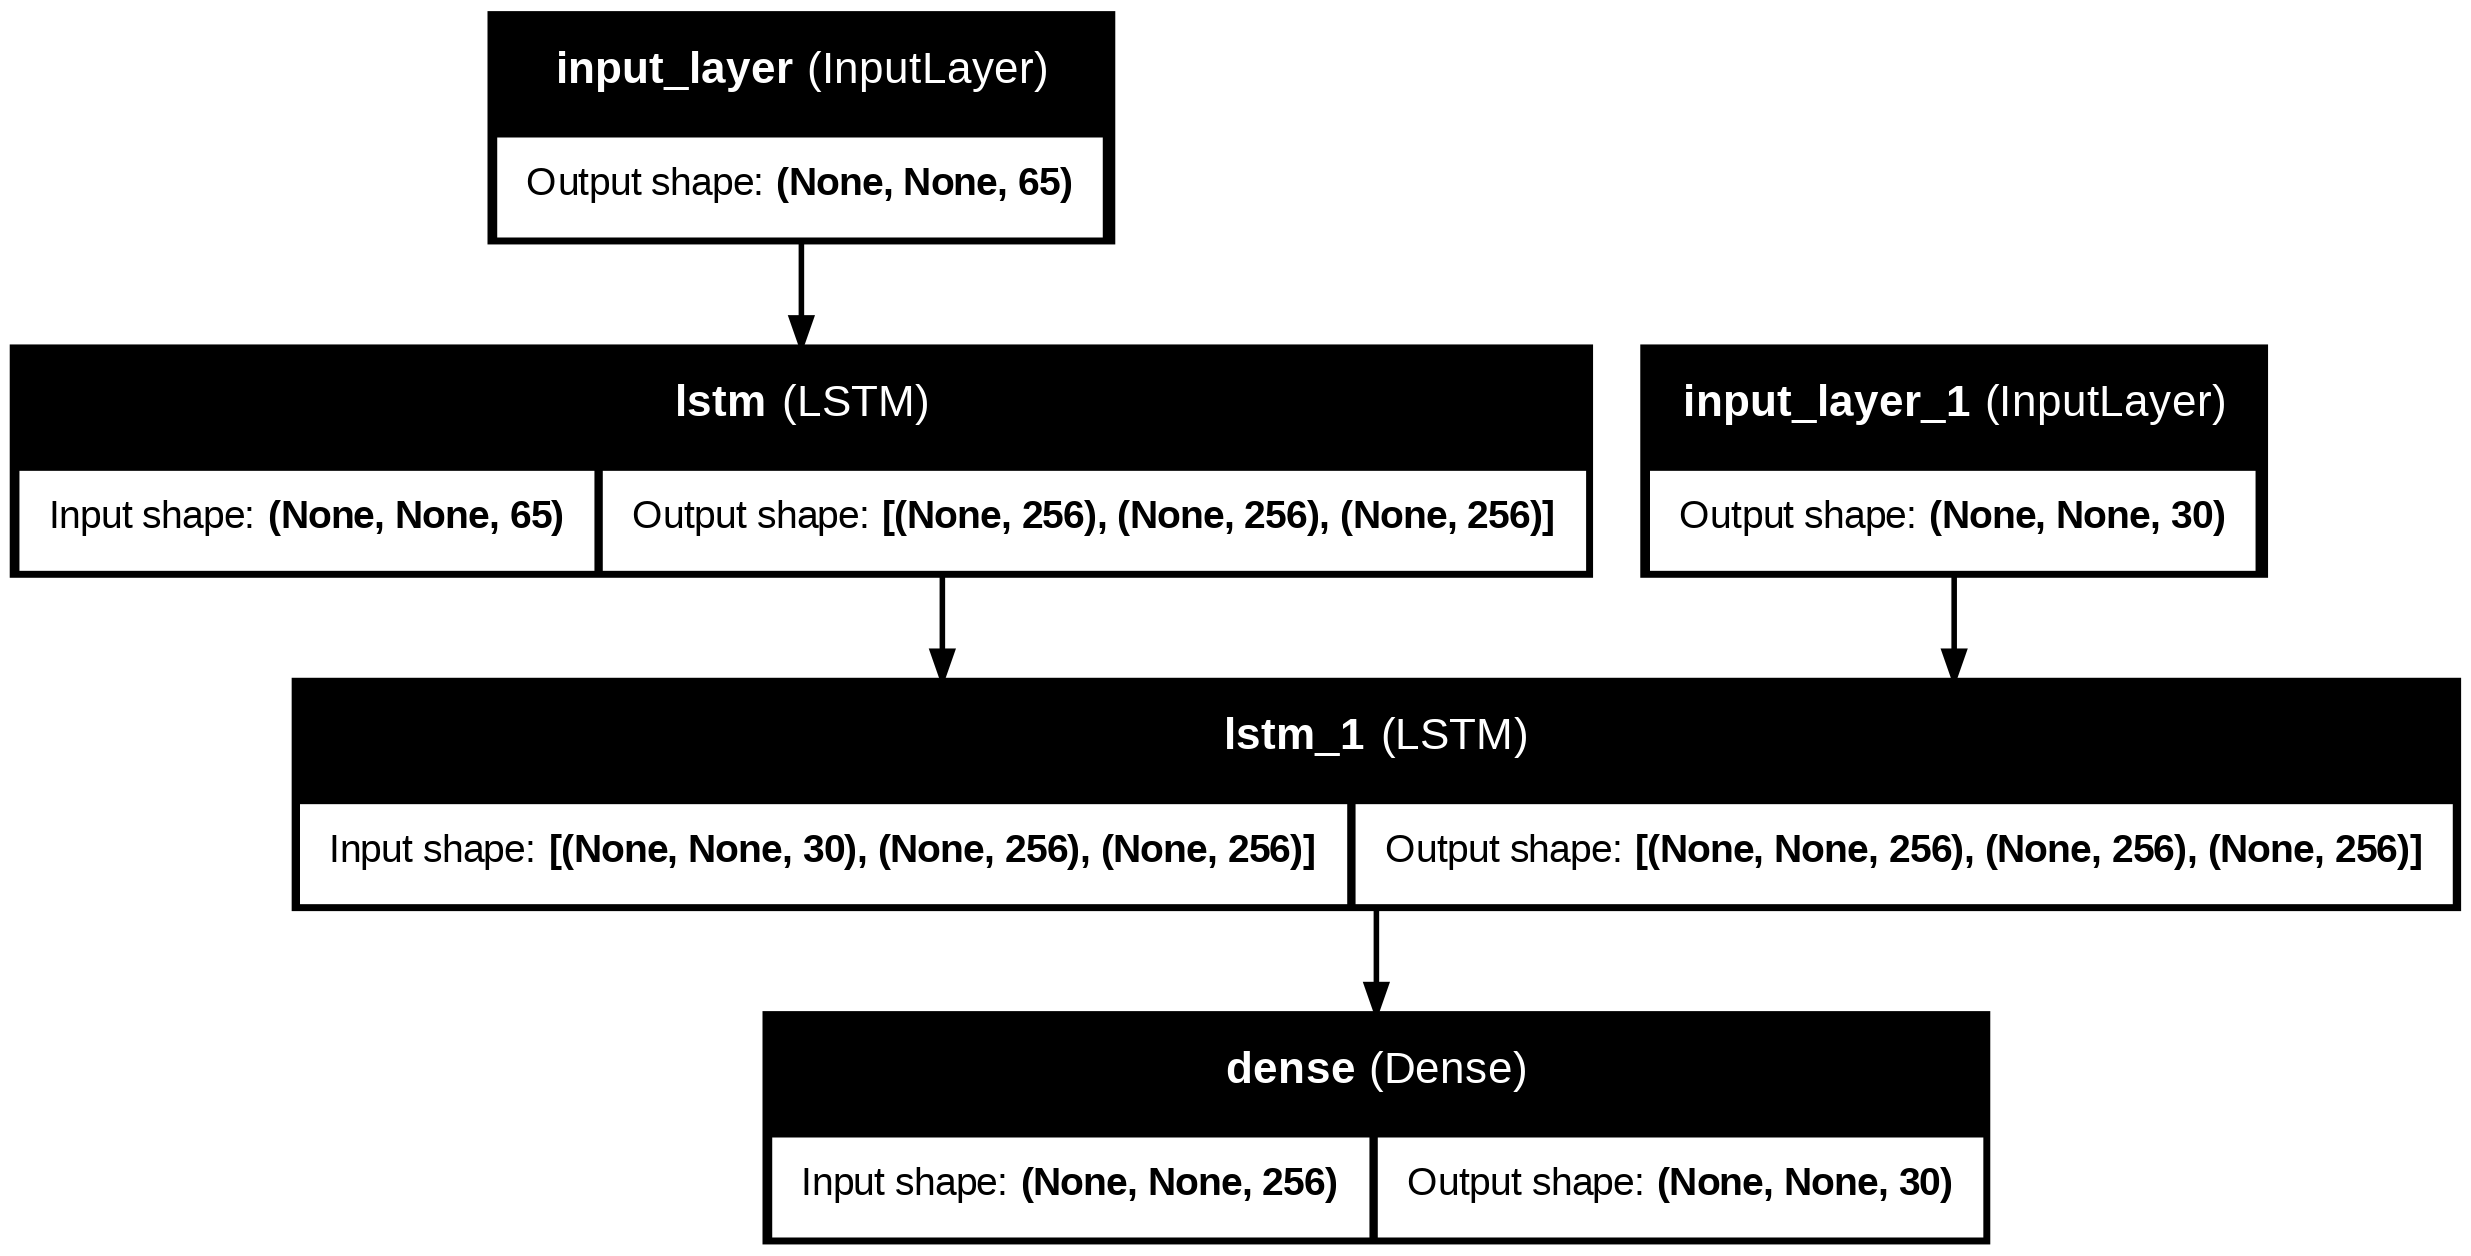

In [41]:
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

## Training our model 0

In [42]:
model_history_0 = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6911 - loss: 1.1285 - val_accuracy: 0.7862 - val_loss: 0.7070
Epoch 2/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8160 - loss: 0.6054 - val_accuracy: 0.8580 - val_loss: 0.4402
Epoch 3/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8803 - loss: 0.3767 - val_accuracy: 0.9012 - val_loss: 0.3078
Epoch 4/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9126 - loss: 0.2744 - val_accuracy: 0.9236 - val_loss: 0.2388
Epoch 5/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9312 - loss: 0.2176 - val_accuracy: 0.9348 - val_loss: 0.2044
Epoch 6/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9439 - loss: 0.1789 - val_accuracy: 0.9434 - val_loss: 0.1785
Epoch 7/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9522 - loss: 0.1535 - val_accuracy: 0.9505 - val_loss: 0.1564
Epoch 8/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9585 - loss: 0.

In [43]:
model.save("model_2.keras")

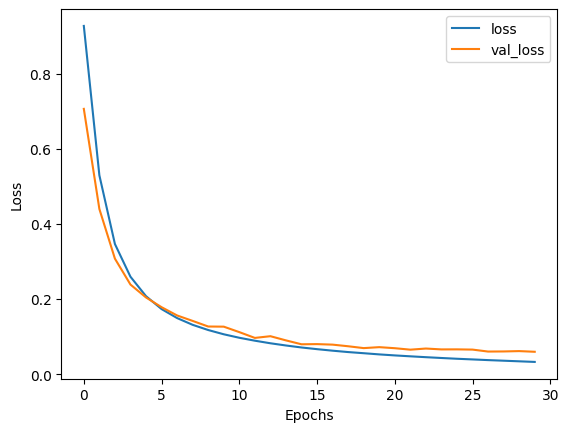

In [44]:
import matplotlib.pyplot as plt

plt.plot(model_history_0.history["loss"], label="loss")
plt.plot(model_history_0.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [45]:
model.evaluate([encoder_test_data, decoder_input_test_data], decoder_target_test_data)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9810 - loss: 0.0596


[0.060563940554857254, 0.9809244275093079]

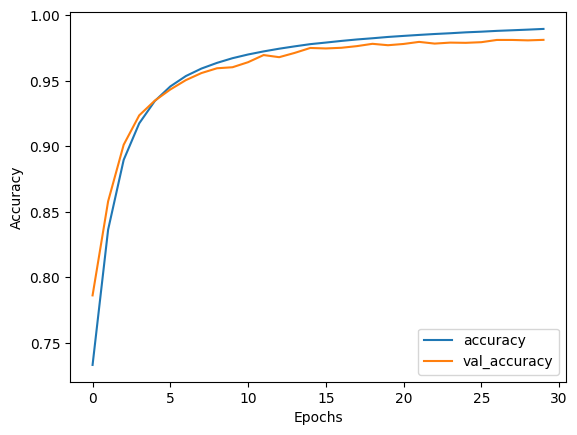

In [46]:
plt.plot(model_history_0.history["accuracy"], label="accuracy")
plt.plot(model_history_0.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## Translation

In [47]:
model = keras.models.load_model("model_2.keras")

In [48]:
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

In [49]:
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(LATENT_DIM,))
decoder_state_input_c = keras.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [50]:
reverse_input_char_index = dict((i, char) for char, i in stoi_devanagari.items())
reverse_target_char_index = dict((i, char) for char, i in stoi_roman.items())

In [51]:

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, stoi_roman["<"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        # decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == ">" or len(decoded_sentence) > max_output_sequence_length:
            stop_condition = True
        else:
          decoded_sentence += sampled_char

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [52]:
for seq_index in range(5,100,10):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("\n")
    print(f"Input word: {input_texts[seq_index]}")
    print(f"Output word: {decoded_sentence}")



Input word: सोचेर
Output word: sochera


Input word: अन्ततिर
Output word: antatira


Input word: परिषदका
Output word: parishadka


Input word: सिलगड़ी
Output word: silgadai


Input word: रचनाको
Output word: rachanako


Input word: कुनामा
Output word: kunama


Input word: कथानकको
Output word: kathankko


Input word: लेखाइ
Output word: lekhai


Input word: शब्दमा
Output word: shabdama


Input word: दिदीलाई
Output word: didilai


In [53]:
devnagari_text = "मनोज"
devanagari_text_token = [stoi_devanagari[x] for x in devnagari_text]

devanagari_text_token

[41, 36, 61, 24]

In [54]:
def one_hot_encode_text(token: list):
  input_data = np.zeros((max_input_sequence_length, num_encoder_tokens))
  for i, t in enumerate(token):
    input_data[i, t] = 1.0
  input_data[i+1:, stoi_devanagari[pad_token]] = 1.0
  return input_data

In [55]:
input_encoded = one_hot_encode_text(devanagari_text_token).reshape(1, max_input_sequence_length, num_encoder_tokens)

input_encoded.shape

(1, 19, 65)

In [56]:
decode_sequence(input_encoded)

'manoj'

In [57]:
x = encoder_input_data[0]

x = x.reshape(1, max_input_sequence_length, num_encoder_tokens)

In [58]:
decode_sequence(x)

'muskuraundai'

In [59]:
for seq_index in range(1):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("\n")
    print(f"Input word: {input_texts[seq_index]}")
    print(f"Output word: {decoded_sentence}")



Input word: मुस्कुराउँदै
Output word: muskuraundai


In [60]:
x = encoder_input_data[0:1]

x.shape

(1, 19, 65)

In [61]:
def translate(text: str):
  devanagari_text_token = [stoi_devanagari[x] for x in text]
  input_encoded = one_hot_encode_text(devanagari_text_token).reshape(1, max_input_sequence_length, num_encoder_tokens)
  return decode_sequence(input_encoded)
  decoded = decode_sequence(x)
  return decoded

In [62]:
texts = [
    "नेपाल",
    "मेरो",
    "सुन्दर",
    "देश",
    "खुशी",
    "सगरमाथा",
    "राम्रो",
    "लामो",
    "किताब",
    "पुस्तक",
    "खाना"
]

In [63]:
for text in texts:
  print(f"Devanagari: {text} \t Roman: {translate(text)}")

Devanagari: नेपाल 	 Roman: nepal
Devanagari: मेरो 	 Roman: mero
Devanagari: सुन्दर 	 Roman: sunder
Devanagari: देश 	 Roman: desh
Devanagari: खुशी 	 Roman: khushi
Devanagari: सगरमाथा 	 Roman: sagarmatha
Devanagari: राम्रो 	 Roman: ramro
Devanagari: लामो 	 Roman: lamo
Devanagari: किताब 	 Roman: kitab
Devanagari: पुस्तक 	 Roman: pustak
Devanagari: खाना 	 Roman: khana


## Text inference

In [64]:
text = "सहकारी ठगी संगठित अपराध र सम्पत्ति शुद्धीकरणसम्बन्धी कसूरमा अनुसन्धानका लागि वीरगन्ज ल्याइएका राष्ट्रिय स्वतन्त्र पार्टी रास्वपा का सभापति रवि लामिछानेसँग मंगलबार पर्सा सरकारी वकिलको कार्यालयमा करिब  घन्टा बयान लिइएको छ"

translated = []

for t in text.split():
  print(f"Devanagari: {t} \t Roman: {translate(t)}")
  translated.append(translate(t))

Devanagari: सहकारी 	 Roman: sahakari
Devanagari: ठगी 	 Roman: thagi
Devanagari: संगठित 	 Roman: sangathit
Devanagari: अपराध 	 Roman: aparadh
Devanagari: र 	 Roman: rupma
Devanagari: सम्पत्ति 	 Roman: sampatti
Devanagari: शुद्धीकरणसम्बन्धी 	 Roman: shuddhikaransambandhi
Devanagari: कसूरमा 	 Roman: kasurma
Devanagari: अनुसन्धानका 	 Roman: anusandhanka
Devanagari: लागि 	 Roman: lagi
Devanagari: वीरगन्ज 	 Roman: virganj
Devanagari: ल्याइएका 	 Roman: lyaieka
Devanagari: राष्ट्रिय 	 Roman: rashtriya
Devanagari: स्वतन्त्र 	 Roman: swatantra
Devanagari: पार्टी 	 Roman: parti
Devanagari: रास्वपा 	 Roman: raswapa
Devanagari: का 	 Roman: kat
Devanagari: सभापति 	 Roman: sabhapati
Devanagari: रवि 	 Roman: ravi
Devanagari: लामिछानेसँग 	 Roman: lamichhanesanga
Devanagari: मंगलबार 	 Roman: mangalbar
Devanagari: पर्सा 	 Roman: parsa
Devanagari: सरकारी 	 Roman: sarkari
Devanagari: वकिलको 	 Roman: wakilko
Devanagari: कार्यालयमा 	 Roman: karyalayama
Devanagari: करिब 	 Roman: karib
Devanagari: घन्टा 	 Roma

In [65]:
" ".join(translated)

'sahakari thagi sangathit aparadh rupma sampatti shuddhikaransambandhi kasurma anusandhanka lagi virganj lyaieka rashtriya swatantra parti raswapa kat sabhapati ravi lamichhanesanga mangalbar parsa sarkari wakilko karyalayama karib ghanta bayan liieko chha'

In [67]:
import re

# Nepali to English number mapping
nepali_to_english_numbers = {
    "०": "0",
    "१": "1",
    "२": "2",
    "३": "3",
    "४": "4",
    "५": "5",
    "६": "6",
    "७": "7",
    "८": "8",
    "९": "9",
    "।": "."
}

def clean_and_map_nepali_text(text):
    """
    Cleans Nepali text by removing punctuation and mapping Nepali numbers to English.

    Args:
        text (str): Input Nepali text.

    Returns:
        str: Cleaned and processed text.
    """
    # Define the characters to remove (punctuation and special symbols)
    pattern = r"[।,!?\"'।।‘’“”():;—-]|[०-९]|[0-9]|\."

    # Remove punctuation
    cleaned_text = re.sub(pattern, "", text)

    # Replace Nepali numbers with English numbers
    for nep_num, eng_num in nepali_to_english_numbers.items():
        cleaned_text = cleaned_text.replace(nep_num, eng_num)

    return cleaned_text

# Example usage
nepali_text = "०७८ साउन १९ मा एकैदिन चार करोड ९१ लाख ९४ हजार रुपैयाँ सारिएको प्रतिवेदनमा उल्लेख छ । गोर्खा मिडियाका उपाध्यक्ष छविलाल जोशीको घरबाट बरामद भएको हार्ड डिस्कमा सानो पाइला सहकारीबाट पनि रकम सिधै गोर्खा मिडियामा सारिएको फेला परेको हो । प्रहरीका अनुसार सानो पाइला सहकारीका अध्यक्ष अनन्तबाबु राई, सचिव देवेन्द्रबाबु राई, कोषाध्यक्ष कुमार रम्तेल, प्रबन्धक असरफ अली सिद्धिकी, संरक्षक गीतेन्द्रबाबु (जीबी) राईलगायत ११ जना हालसम्म फरार छन् । सहकारीकी पूर्वउपाध्यक्ष नेहा पौडेल गत साउन २१ मा जिल्ला अदालत पर्साबाट न्यायीक परीक्षण हुँदा ठहरेबमोजिम हुने गरी हाललाई एक करोड १० लाख धरौटीमा रिहा भइन् । यसैगरी सहकारीका कर्मचारी राधेचन्द्र यादव पनि ३५ लाख रुपैयाँ धरौटीमा रिहा भएका छन् ।"
cleaned_text = clean_and_map_nepali_text(nepali_text)
print(cleaned_text)


 साउन  मा एकैदिन चार करोड  लाख  हजार रुपैयाँ सारिएको प्रतिवेदनमा उल्लेख छ  गोर्खा मिडियाका उपाध्यक्ष छविलाल जोशीको घरबाट बरामद भएको हार्ड डिस्कमा सानो पाइला सहकारीबाट पनि रकम सिधै गोर्खा मिडियामा सारिएको फेला परेको हो  प्रहरीका अनुसार सानो पाइला सहकारीका अध्यक्ष अनन्तबाबु राई सचिव देवेन्द्रबाबु राई कोषाध्यक्ष कुमार रम्तेल प्रबन्धक असरफ अली सिद्धिकी संरक्षक गीतेन्द्रबाबु जीबी राईलगायत  जना हालसम्म फरार छन्  सहकारीकी पूर्वउपाध्यक्ष नेहा पौडेल गत साउन  मा जिल्ला अदालत पर्साबाट न्यायीक परीक्षण हुँदा ठहरेबमोजिम हुने गरी हाललाई एक करोड  लाख धरौटीमा रिहा भइन्  यसैगरी सहकारीका कर्मचारी राधेचन्द्र यादव पनि  लाख रुपैयाँ धरौटीमा रिहा भएका छन् 


In [68]:
def translate_text(text):
  text = clean_and_map_nepali_text(text)
  pattern = r"[।,!?\"'।।‘’“”():;—-]|[०-९]|[0-9]|\."

  # Remove punctuation
  cleaned_text = re.sub(pattern, "", text)
  return " ".join(translate(t) for t in cleaned_text.split())

In [69]:
translate_text(nepali_text)

'sauna mat ekaidin char karod lakh hazar rupaiyan sarieko pratiwedanma ullekh chha gorkha midiaka upadhyaksha chhawilal joshiko gharbata baramad bhaeko hard diskma sano paila sahakaribata pani rakam sidhai gorkha midiama sarieko fela pareko hoit praharika anusar sano paila sahakarika adhyaksha anantababu rai sachiva devendrababa rai koshadhyaksha kumar ramtel prabandhak assharf ally siddhiki sanrakshak gitendrababu jgb rilgayat jana halsamma farra chhan sahakariki purwaupadhyaksha neha paudel gatta sauna mat jilla adalat parsabata nayic parikshan hunda thaharebmojim hune gari hallai eke karod lakh dharautima riha bhin yasaigari sahakarika karmachari radhechandra yadav pani lakh rupaiyan dharautima riha bhaeka chhan'